# Face swapping program using OpenCV
## By P.S.Sai Ganesh

The following program shows how a face can be swapped from one image to another image. Initially all the steps done to swap the faces are shown. In the end, a function is built that can be used to swap faces when the images are given as input. The function follows the same steps as mentioned bellow :

* [Step 1 : Read the images and convert to grayscale](#step1)
* [Step 2 : Get the landmark points for the faces](#step2)
* [Step 3 : Convert the faces into delaunay triangles using the landmark points](#step3)
* [Step 4 : Match the dimensions of the triangles by warping](#step4)
* [Step 5 : Swap the face masks generated to form the resulting image](#step5)
* [Step 6 : Use the seamlessClone function to match the outlines clearly](#step6)
* [Function to swap faces given two images](#function)

In [1]:
#All the imports necessary for the face swapping
import cv2
import dlib

from matplotlib import pyplot as plt
import numpy as np

<a id="step1"></a>

## Step 1 : Reading the images

The first step is to read the two images that will have the faces swapped.
This is done using "cv2.imread" and the images are converted to their grayscale version
and stored in another variable

In [2]:
#Read the image when given the path
img1 = cv2.imread(r'../input/face-swap/Face1.jpg')
img2 = cv2.imread(r'../input/face-swap/Face3.jpg')

#Convert images to grayscale from RGB
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

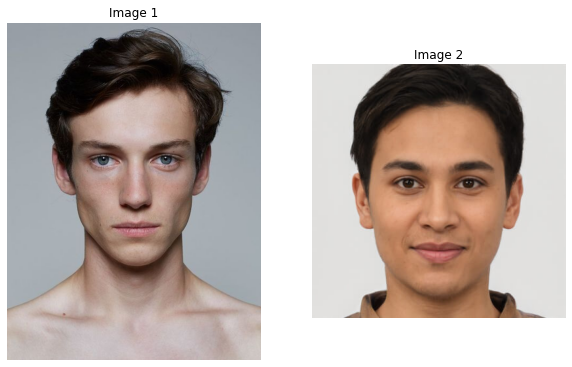

In [3]:
fig, axs = plt.subplots(1,2,figsize=(10,10));

axs[0].imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB));
axs[0].set_title("Image 1")

axs[1].imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB));
axs[1].set_title("Image 2")

[axi.axis('off') for axi in axs.ravel()]
fig.show()

<a id="step2"></a>

## Step 2 : Get the points for the landmarks of the face

Load the model to detect faces as well as the predictor to find the shape of the face or the outline of the face both from the dlib library.

In [4]:
#Loading models and predict_outs of the dlib library to detect landmarks in both images
detect_face = dlib.get_frontal_face_detector()
predict_out = dlib.shape_predictor(r'../input/shape-predictor-68-face-landmarksdat/shape_predictor_68_face_landmarks.dat')

#Function to get the landmark points given a grayscale image as input
def get_landmarks(img_gray):
    
    bound_rect = detect_face(img_gray)[0]

    #The values that act as the x and y coordinates of the outline on the face
    landmarks = predict_out(img_gray, bound_rect)
    landmarks_points = [] 

    for n in range(68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))

    points = np.array(landmarks_points, np.int32)
    
    return points,landmarks_points

#Function to get the convexhull given the image and the landmark points
def get_convexhull(img, points):
    
    #Find height and width of image ignoring the channels
    height, width, _ = img.shape
    
    mask = np.zeros((height, width), np.uint8)
    
    convexhull = cv2.convexHull(points) 
    
    return convexhull

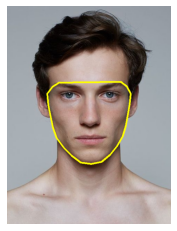

In [5]:
#Getting the landmark points and convexhull for image 1
img1_points, img1_landmarks = get_landmarks(img1_gray)
img1_convex = get_convexhull(img1,img1_points)
img1_cp = img1.copy()

plt.imshow(cv2.cvtColor((cv2.polylines(img1_cp, [img1_convex], True, (0,255,255), 3)), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

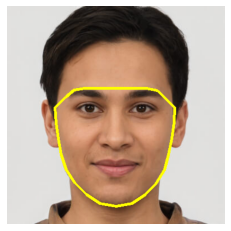

In [6]:
#Getting the landmark points and convexhull for image 2
img2_points, img2_landmarks = get_landmarks(img2_gray)
img2_convex = get_convexhull(img2,img2_points)
img2_cp = img2.copy()

plt.imshow(cv2.cvtColor((cv2.polylines(img2_cp, [img2_convex], True, (0,255,255), 3)), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

<a id="step3"></a>

## Step 3 : Convert the face to triangles

In this step, the face is segmented into triangles so that in only these triangles can be exchanged between the images.
This is done using the delaunay triangulation.

Why this step is important?

The face cant be just replaced on the whole because they might have different size and perspective. When we split the face into triangles, only these triangles can be swapped and this way the original proportions are not lost.

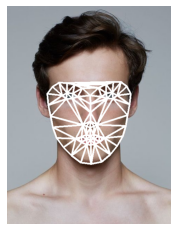

In [7]:
#Starting the delaunay triangulation
bound_rect = cv2.boundingRect(img1_convex)

points_subdiv = cv2.Subdiv2D(bound_rect)
points_subdiv.insert(img1_landmarks)

#Creating the triangle list
triangles = points_subdiv.getTriangleList()
triangles = np.array(triangles, dtype=np.int32)

triangle_coords = []
img1_cp = img1.copy()

#Returns index given the array
def get_index(arr):
    index = 0
    if arr[0]:
        index = arr[0][0]
    return index

#To form the coordinates for the triangle
for triangle in triangles :

    #The vertices of the triangle
    pt1 = (triangle[0], triangle[1])
    pt2 = (triangle[2], triangle[3])
    pt3 = (triangle[4], triangle[5])
    
    cv2.line(img1_cp, pt1, pt2, (255, 255, 255), 3,  0)
    cv2.line(img1_cp, pt2, pt3, (255, 255, 255), 3,  0)
    cv2.line(img1_cp, pt3, pt1, (255, 255, 255), 3,  0)
    
    #Indices of landmark points are taken to construct similar triangulation
    index_pt1 = np.where((img1_points == pt1).all(axis=1))
    index_pt1 = get_index(index_pt1)
    index_pt2 = np.where((img1_points == pt2).all(axis=1))
    index_pt2 = get_index(index_pt2)
    index_pt3 = np.where((img1_points == pt3).all(axis=1))
    index_pt3 = get_index(index_pt3)

    #Append coordinates only if triangle has 3 vertices or triangle is present
    if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
        vertices = [index_pt1, index_pt2, index_pt3]
        triangle_coords.append(vertices)

plt.imshow(cv2.cvtColor(img1_cp, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

<a id="step4"></a>

## Step 4 : Warping the triangles to match dimension

The triangles of the first face are taken and distorted to the triangles of the second image so that the dimensions of the face matches. This will make sure that the images retain their facial features.

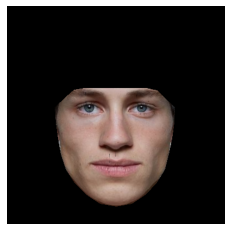

In [8]:
height, width, channels = img2.shape
new_img1 = np.zeros((height, width, channels), np.uint8)
img2_new_img1 = np.zeros((height, width, channels), np.uint8)

height, width = img1_gray.shape
new_img_mask = np.zeros((height, width), np.uint8)

#Going through each triangle of first person's face
for triangle in triangle_coords:

    #Points of the image 1 delaunay triangles
    pt1 = img1_landmarks[triangle[0]]
    pt2 = img1_landmarks[triangle[1]]
    pt3 = img1_landmarks[triangle[2]]

    #Obtaining the triangle coordinates
    (x, y, w, height) = cv2.boundingRect(np.array([pt1, pt2, pt3], np.int32))
    cropped_triangle = img1[y: y+height, x: x+w]
    
    #Creating a mask
    cropped_mask = np.zeros((height, w), np.uint8)

    #Filling the triangle to generate the mask
    points = np.array([[pt1[0]-x, pt1[1]-y], [pt2[0]-x, pt2[1]-y], [pt3[0]-x, pt3[1]-y]], np.int32)
    cv2.fillConvexPoly(cropped_mask, points, 255)

    cv2.line(new_img_mask, pt1, pt2, 255)
    cv2.line(new_img_mask, pt2, pt3, 255)
    cv2.line(new_img_mask, pt1, pt3, 255)

    lines_space = cv2.bitwise_and(img1, img1, mask=new_img_mask)

    #Finding the delaunay triangles for the second image

    #Points of the image 2 delaunay triangles
    pt1 = img2_landmarks[triangle[0]]
    pt2 = img2_landmarks[triangle[1]]
    pt3 = img2_landmarks[triangle[2]]

    #Obtaining the triangle coordinates
    (x, y, w, height) = cv2.boundingRect(np.array([pt1, pt2, pt3], np.int32))
    cropped_mask2 = np.zeros((height,w), np.uint8)

    #Filling the triangle to generate the mask
    points2 = np.array([[pt1[0]-x, pt1[1]-y], [pt2[0]-x, pt2[1]-y], [pt3[0]-x, pt3[1]-y]], np.int32)
    cv2.fillConvexPoly(cropped_mask2, points2, 255)

    #Warping the given image to the target image
    points =  np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2) 
    dist_triangle = cv2.warpAffine(cropped_triangle, M, (w, height))
    dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=cropped_mask2)

    #Combining all the triangles to match the target image's triangles
    img2_new_img1_bound_rect_area = img2_new_img1[y: y+height, x: x+w]
    img2_new_img1_bound_rect_area_gray = cv2.cvtColor(img2_new_img1_bound_rect_area, cv2.COLOR_BGR2GRAY)

    #Mask 
    masked_triangle = cv2.threshold(img2_new_img1_bound_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=masked_triangle[1])
    
    #Updating the face mask
    img2_new_img1_bound_rect_area = cv2.add(img2_new_img1_bound_rect_area, dist_triangle)
    img2_new_img1[y: y+height, x: x+w] = img2_new_img1_bound_rect_area

plt.imshow(cv2.cvtColor(img2_new_img1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

<a id="step5"></a>

## Step 5 : Swap face masks

This step is simple, the face masks generated by the above step are swapped and the result image is formed. But, the colors and saturation of the edges are very different.

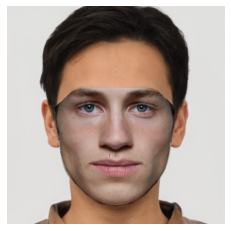

In [9]:
img2_img1_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_img1_mask, img2_convex, 255)
img2_img1_mask = cv2.bitwise_not(img2_head_mask)

img2_maskless = cv2.bitwise_and(img2, img2, mask=img2_img1_mask)
result = cv2.add(img2_maskless, img2_new_img1)

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

<a id="step6"></a>

## Step 6 : Smooth the edges

To solve the discolouration, the edges are smoothed to make the masks look the same, this is done using the seamlessClone function of the OpenCV.
The attribute MIXED_CLONE gives better output in some cases, but most of the times NORMAL_CLONE gives a valid output.

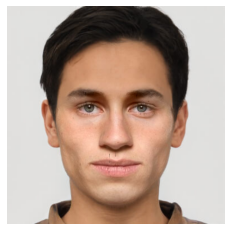

In [10]:
#Getting the center center of face
(x, y, w, height) = cv2.boundingRect(img2_convex)
face_center = (int((x+x+w)/2), int((y+y+height)/2))

#Creating the seamless clone 
seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, face_center, cv2.NORMAL_CLONE)

plt.imshow(cv2.cvtColor(seamlessclone, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

<a id="function"></a>

## Function to swap faces

The following is a function that can be used to swap the faces on two images given the images as input.

Note : The input images need to be in the RGB format.

In [11]:
def face_swap(image_1,image_2):
    
    if(image_1.shape[2] != 3 or image_2.shape[2] != 3):
        print("The input images do not have 3 channels (RGB)");
        return;
    
    #Converting the images to graysclae
    img1_gray = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
    
    #Detectors and predictor 
    detect_face = dlib.get_frontal_face_detector()
    predict_out = dlib.shape_predictor(r'../input/shape-predictor-68-face-landmarksdat/shape_predictor_68_face_landmarks.dat')
    
    #Function to get the landmark points given a grayscale image as input
    def get_landmarks(img_gray):
    
        bound_rect = detect_face(img_gray)[0]
    
        #The values that act as the x and y coordinates of the outline on the face
        landmarks = predict_out(img_gray, bound_rect)
        landmarks_points = [] 

        for n in range(68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            landmarks_points.append((x, y))

        points = np.array(landmarks_points, np.int32)

        return points,landmarks_points
    
    #Getting the landmark points and convexhull for image 1
    img1_points, img1_landmarks = get_landmarks(img1_gray)
    img1_convex = cv2.convexHull(img1_points)
    
    #Getting the landmark points and convexhull for image 2
    img2_points, img2_landmarks = get_landmarks(img2_gray)
    img2_convex = cv2.convexHull(img2_points)
    
    bound_rect = cv2.boundingRect(img1_convex)

    points_subdiv = cv2.Subdiv2D(bound_rect)
    points_subdiv.insert(img1_landmarks)
    
    triangles = points_subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    #Creating the delaunay triangles for image 1
    triangle_coords = []
    img1_cp = image_1.copy()

    def get_index(arr):
        index = 0
        if arr[0]:
            index = arr[0][0]
        return index

    for triangle in triangles :

        #Obtain the vertices of the triangle
        pt1 = (triangle[0], triangle[1])
        pt2 = (triangle[2], triangle[3])
        pt3 = (triangle[4], triangle[5])

        cv2.line(img1_cp, pt1, pt2, (255, 255, 255), 3,  0)
        cv2.line(img1_cp, pt2, pt3, (255, 255, 255), 3,  0)
        cv2.line(img1_cp, pt3, pt1, (255, 255, 255), 3,  0)

        index_pt1 = np.where((img1_points == pt1).all(axis=1))
        index_pt1 = get_index(index_pt1)
        index_pt2 = np.where((img1_points == pt2).all(axis=1))
        index_pt2 = get_index(index_pt2)
        index_pt3 = np.where((img1_points == pt3).all(axis=1))
        index_pt3 = get_index(index_pt3)

        #Append coordinates only if triangle exists
        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            vertices = [index_pt1, index_pt2, index_pt3]
            triangle_coords.append(vertices)

    height, width, channels = image_2.shape
    new_img1 = np.zeros((height, width, channels), np.uint8)
    img2_new_img1 = np.zeros((height, width, channels), np.uint8)

    height, width = img1_gray.shape
    new_img_mask = np.zeros((height, width), np.uint8)


    for triangle in triangle_coords:

        #Coordinates of the triangle for the first person
        pt1 = img1_landmarks[triangle[0]]
        pt2 = img1_landmarks[triangle[1]]
        pt3 = img1_landmarks[triangle[2]]

        #Obtain the triangle coordinates
        (x, y, w, h) = cv2.boundingRect(np.array([pt1, pt2, pt3], np.int32))
        cropped_triangle = image_1[y: y+h, x: x+w]
        
        cropped_mask = np.zeros((h, w), np.uint8)

        points = np.array([[pt1[0]-x, pt1[1]-y], [pt2[0]-x, pt2[1]-y], [pt3[0]-x, pt3[1]-y]], np.int32)
        cv2.fillConvexPoly(cropped_mask, points, 255)

        cv2.line(new_img_mask, pt1, pt2, 255)
        cv2.line(new_img_mask, pt2, pt3, 255)
        cv2.line(new_img_mask, pt1, pt3, 255)

        lines_space = cv2.bitwise_and(image_1, image_1, mask=new_img_mask)

        #Obtaining the delaunay triangles for the person 2

        #Coordinates of the triangle for image 2
        pt1 = img2_landmarks[triangle[0]]
        pt2 = img2_landmarks[triangle[1]]
        pt3 = img2_landmarks[triangle[2]]

        #Obtain the triangle coordinates
        (x, y, w, h) = cv2.boundingRect(np.array([pt1, pt2, pt3], np.int32))
        cropped_mask2 = np.zeros((h,w), np.uint8)

        points2 = np.array([[pt1[0]-x, pt1[1]-y], [pt2[0]-x, pt2[1]-y], [pt3[0]-x, pt3[1]-y]], np.int32)
        cv2.fillConvexPoly(cropped_mask2, points2, 255)

        #Warping the triangle to match the dimensions
        points =  np.float32(points)
        points2 = np.float32(points2)
        M = cv2.getAffineTransform(points, points2)  
        dist_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
        dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=cropped_mask2)

        img2_new_img1_bound_rect_area = img2_new_img1[y: y+h, x: x+w]
        img2_new_img1_bound_rect_area_gray = cv2.cvtColor(img2_new_img1_bound_rect_area, cv2.COLOR_BGR2GRAY)

        masked_triangle = cv2.threshold(img2_new_img1_bound_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
        dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=masked_triangle[1])

        img2_new_img1_bound_rect_area = cv2.add(img2_new_img1_bound_rect_area, dist_triangle)
        img2_new_img1[y: y+h, x: x+w] = img2_new_img1_bound_rect_area
    
    #Combining the masks
    img2_img1_mask = np.zeros_like(img2_gray)
    img2_head_mask = cv2.fillConvexPoly(img2_img1_mask, img2_convex, 255)
    img2_img1_mask = cv2.bitwise_not(img2_head_mask)

    img2_maskless = cv2.bitwise_and(image_2, image_2, mask=img2_img1_mask)
    result = cv2.add(img2_maskless, img2_new_img1)
    
    #Making the seamlessClone for better output
    (x, y, w, h) = cv2.boundingRect(img2_convex)
    face_center = (int((x+x+w)/2), int((y+y+h)/2))

    final_swapped_image = cv2.seamlessClone(result, image_2, img2_head_mask, face_center, cv2.NORMAL_CLONE)
    
    return final_swapped_image

In [16]:
#Testing the function with two images
imag1 = cv2.imread(r'../input/face-swap/Face3.jpg')
imag2 = cv2.imread(r'../input/face-swap/Face4.jpg')

In [15]:
#Swap faces in both ways
final_image_1 = face_swap(imag1,imag2)
final_image_2 = face_swap(imag2,imag1)

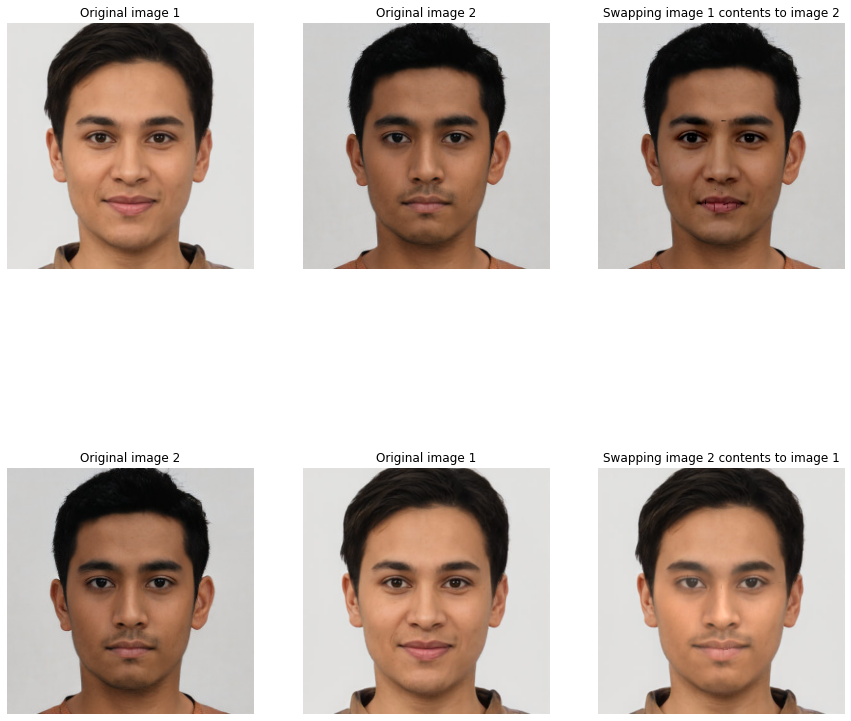

In [14]:
fig, axs = plt.subplots(2,3,figsize=(15,15));

axs[0,0].imshow(cv2.cvtColor(imag1,cv2.COLOR_BGR2RGB));
axs[0,0].set_title("Original image 1")
axs[0,1].imshow(cv2.cvtColor(imag2,cv2.COLOR_BGR2RGB));
axs[0,1].set_title("Original image 2")
axs[0,2].imshow(cv2.cvtColor(final_image_1,cv2.COLOR_BGR2RGB));
axs[0,2].set_title("Swapping image 1 contents to image 2")

axs[1,0].imshow(cv2.cvtColor(imag2,cv2.COLOR_BGR2RGB));
axs[1,0].set_title("Original image 2")
axs[1,1].imshow(cv2.cvtColor(imag1,cv2.COLOR_BGR2RGB));
axs[1,1].set_title("Original image 1")
axs[1,2].imshow(cv2.cvtColor(final_image_2,cv2.COLOR_BGR2RGB));
axs[1,2].set_title("Swapping image 2 contents to image 1")

[axi.axis('off') for axi in axs.ravel()]
fig.show()